### XGBoost

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
### 定义二叉特征分裂函数
def feature_split(X, feature_i, threshold):
    split_func = None
    if isinstance(threshold, int) or isinstance(threshold, float):
        split_func = lambda sample: sample[feature_i] >= threshold
    else:
        split_func = lambda sample: sample[feature_i] == threshold

    X_left = np.array([sample for sample in X if split_func(sample)])
    X_right = np.array([sample for sample in X if not split_func(sample)])
    return np.array([X_left, X_right])

### 计算基尼指数
def calculate_gini(y):
    y = y.tolist()
    probs = [y.count(i)/len(y) for i in np.unique(y)]
    gini = sum([p*(1-p) for p in probs])
    return gini
	
### 打乱数据
def data_shuffle(X, y, seed=None):
    if seed:
        np.random.seed(seed)
    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)
    return X[idx], y[idx]
	
### 类别标签转换
def cat_label_convert(y, n_col=None):
    if not n_col:
        n_col = np.amax(y) + 1
    one_hot = np.zeros((y.shape[0], n_col))
    one_hot[np.arange(y.shape[0]), y] = 1
    return one_hot


In [ ]:
### 定义树结点
class TreeNode():
    def __init__(self, feature_i=None, threshold=None,
               leaf_value=None, left_branch=None, right_branch=None):
        # 特征索引
        self.feature_i = feature_i          
        # 特征划分阈值
        self.threshold = threshold 
        # 叶子节点取值
        self.leaf_value = leaf_value   
        # 左子树
        self.left_branch = left_branch     
        # 右子树
        self.right_branch = right_branch
		
### 定义二叉决策树
class BinaryDecisionTree(object):
    ### 决策树初始参数
    def __init__(self, min_samples_split=2, min_gini_impurity=999,
                 max_depth=float("inf"), loss=None):
        # 根结点
        self.root = None  
        # 节点最小分裂样本数
        self.min_samples_split = min_samples_split
        # 节点初始化基尼不纯度
        self.min_gini_impurity = min_gini_impurity
        # 树最大深度
        self.max_depth = max_depth
        # 基尼不纯度计算函数
        self.gini_impurity_calculation = None
        # 叶子节点值预测函数
        self._leaf_value_calculation = None
        # 损失函数
        self.loss = loss

    ### 决策树拟合函数
    def fit(self, X, y, loss=None):
        # 递归构建决策树
        self.root = self._build_tree(X, y)
        self.loss=None

    ### 决策树构建函数
    def _build_tree(self, X, y, current_depth=0):
        # 初始化最小基尼不纯度
        init_gini_impurity = 999
        # 初始化最佳特征索引和阈值
        best_criteria = None    
        # 初始化数据子集
        best_sets = None        
        
        if len(np.shape(y)) == 1:
            y = np.expand_dims(y, axis=1)

        # 合并输入和标签
        Xy = np.concatenate((X, y), axis=1)
        # 获取样本数和特征数
        n_samples, n_features = X.shape
        # 设定决策树构建条件
        # 训练样本数量大于节点最小分裂样本数且当前树深度小于最大深度
        if n_samples >= self.min_samples_split and current_depth <= self.max_depth:
            # 遍历计算每个特征的基尼不纯度
            for feature_i in range(n_features):
                # 获取第i特征的所有取值
                feature_values = np.expand_dims(X[:, feature_i], axis=1)
                # 获取第i个特征的唯一取值
                unique_values = np.unique(feature_values)

                # 遍历取值并寻找最佳特征分裂阈值
                for threshold in unique_values:
                    # 特征节点二叉分裂
                    Xy1, Xy2 = feature_split(Xy, feature_i, threshold)
                    # 如果分裂后的子集大小都不为0
                    if len(Xy1) > 0 and len(Xy2) > 0:
                        # 获取两个子集的标签值
                        y1 = Xy1[:, n_features:]
                        y2 = Xy2[:, n_features:]

                        # 计算基尼不纯度
                        impurity = self.impurity_calculation(y, y1, y2)

                        # 获取最小基尼不纯度
                        # 最佳特征索引和分裂阈值
                        if impurity < init_gini_impurity:
                            init_gini_impurity = impurity
                            best_criteria = {"feature_i": feature_i, "threshold": threshold}
                            best_sets = {
                                "leftX": Xy1[:, :n_features],   
                                "lefty": Xy1[:, n_features:],   
                                "rightX": Xy2[:, :n_features],  
                                "righty": Xy2[:, n_features:]   
                                }
        
        # 如果计算的最小不纯度小于设定的最小不纯度
        if init_gini_impurity < self.min_gini_impurity:
            # 分别构建左右子树
            left_branch = self._build_tree(best_sets["leftX"], best_sets["lefty"], current_depth + 1)
            right_branch = self._build_tree(best_sets["rightX"], best_sets["righty"], current_depth + 1)
            return TreeNode(feature_i=best_criteria["feature_i"], threshold=best_criteria["threshold"], left_branch=left_branch, right_branch=right_branch)

        # 计算叶子计算取值
        leaf_value = self._leaf_value_calculation(y)
        return TreeNode(leaf_value=leaf_value)

    ### 定义二叉树值预测函数
    def predict_value(self, x, tree=None):
        if tree is None:
            tree = self.root
        # 如果叶子节点已有值，则直接返回已有值
        if tree.leaf_value is not None:
            return tree.leaf_value
        # 选择特征并获取特征值
        feature_value = x[tree.feature_i]
        # 判断落入左子树还是右子树
        branch = tree.right_branch
        if isinstance(feature_value, int) or isinstance(feature_value, float):
            if feature_value >= tree.threshold:
                branch = tree.left_branch
        elif feature_value == tree.threshold:
            branch = tree.right_branch
        # 测试子集
        return self.predict_value(x, branch)

    ### 数据集预测函数
    def predict(self, X):
        y_pred = [self.predict_value(sample) for sample in X]
        return y_pred

		
		
class ClassificationTree(BinaryDecisionTree):
    ### 定义基尼不纯度计算过程
    def _calculate_gini_impurity(self, y, y1, y2):
        p = len(y1) / len(y)
        gini = calculate_gini(y)
        gini_impurity = p * calculate_gini(y1) + (1-p) * calculate_gini(y2)
        return gini_impurity
    
    ### 多数投票
    def _majority_vote(self, y):
        most_common = None
        max_count = 0
        for label in np.unique(y):
            # 统计多数
            count = len(y[y == label])
            if count > max_count:
                most_common = label
                max_count = count
        return most_common
    
    # 分类树拟合
    def fit(self, X, y):
        self.impurity_calculation = self._calculate_gini_impurity
        self._leaf_value_calculation = self._majority_vote
        super(ClassificationTree, self).fit(X, y)
	
		
### CART回归树
class RegressionTree(BinaryDecisionTree):
	# 计算方差减少量
    def _calculate_variance_reduction(self, y, y1, y2):
        var_tot = np.var(y, axis=0)
        var_y1 = np.var(y1, axis=0)
        var_y2 = np.var(y2, axis=0)
        frac_1 = len(y1) / len(y)
        frac_2 = len(y2) / len(y)
        # 计算方差减少量
        variance_reduction = var_tot - (frac_1 * var_y1 + frac_2 * var_y2)
        return sum(variance_reduction)

    # 节点值取平均
    def _mean_of_y(self, y):
        value = np.mean(y, axis=0)
        return value if len(value) > 1 else value[0]

	# 回归树拟合
    def fit(self, X, y):
        self.impurity_calculation = self._calculate_variance_reduction
        self._leaf_value_calculation = self._mean_of_y
        super(RegressionTree, self).fit(X, y)


In [8]:
### XGBoost单棵树类
class XGBoost_Single_Tree(BinaryDecisionTree):
    # 结点分裂方法
    def node_split(self, y):
        # 中间特征所在列
        feature = int(np.shape(y)[1]/2)
        # 左子树为真实值，右子树为预测值
        y_true, y_pred = y[:, :feature], y[:, feature:]
        return y_true, y_pred

    # 信息增益计算方法
    def gain(self, y, y_pred):
        # 梯度计算
        Gradient = np.power((y * self.loss.gradient(y, y_pred)).sum(), 2)
        # Hessian矩阵计算
        Hessian = self.loss.hess(y, y_pred).sum()
        return 0.5 * (Gradient / Hessian)

    # 树分裂增益计算
    # 式(12.28)
    def gain_xgb(self, y, y1, y2):
        # 结点分裂
        y_true, y_pred = self.node_split(y)
        y1, y1_pred = self.node_split(y1)
        y2, y2_pred = self.node_split(y2)
        true_gain = self.gain(y1, y1_pred)
        false_gain = self.gain(y2, y2_pred)
        gain = self.gain(y_true, y_pred)
        return true_gain + false_gain - gain

    # 计算叶子结点最优权重
    def leaf_weight(self, y):
        y_true, y_pred = self.node_split(y)
        # 梯度计算
        gradient = np.sum(y_true * self.loss.gradient(y_true, y_pred), axis=0)
        # hessian矩阵计算
        hessian = np.sum(self.loss.hess(y_true, y_pred), axis=0)
        # 叶子结点得分
        leaf_weight =  gradient / hessian
        return leaf_weight

    # 树拟合方法
    def fit(self, X, y):
        self.impurity_calculation = self.gain_xgb
        self._leaf_value_calculation = self.leaf_weight
        super(XGBoost_Single_Tree, self).fit(X, y)

In [9]:
### 分类损失函数定义
# 定义Sigmoid类
class Sigmoid:
    def __call__(self, x):
        return 1 / (1 + np.exp(-x))

    def gradient(self, x):
        return self.__call__(x) * (1 - self.__call__(x))

# 定义Logit损失
class LogisticLoss:
    def __init__(self):
        sigmoid = Sigmoid()
        self._func = sigmoid
        self._grad = sigmoid.gradient
    
    # 定义损失函数形式
    def loss(self, y, y_pred):
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        p = self._func(y_pred)
        return y * np.log(p) + (1 - y) * np.log(1 - p)

    # 定义一阶梯度
    def gradient(self, y, y_pred):
        p = self._func(y_pred)
        return -(y - p)

    # 定义二阶梯度
    def hess(self, y, y_pred):
        p = self._func(y_pred)
        return p * (1 - p)

In [10]:
### XGBoost定义
class XGBoost:
    def __init__(self, n_estimators=300, learning_rate=0.001, 
                 min_samples_split=2,
                 min_gini_impurity=999, 
                 max_depth=2):
        # 树的棵树
        self.n_estimators = n_estimators
        # 学习率
        self.learning_rate = learning_rate 
        # 结点分裂最小样本数
        self.min_samples_split = min_samples_split 
        # 结点最小基尼不纯度
        self.min_gini_impurity = min_gini_impurity  
        # 树最大深度
        self.max_depth = max_depth                  
        # 用于分类的对数损失
        # 回归任务可定义平方损失 
        # self.loss = SquaresLoss()
        self.loss = LogisticLoss()
        # 初始化分类树列表
        self.trees = []
        # 遍历构造每一棵决策树
        for _ in range(n_estimators):
            tree = XGBoost_Single_Tree(
                    min_samples_split=self.min_samples_split,
                    min_gini_impurity=self.min_gini_impurity,
                    max_depth=self.max_depth,
                    loss=self.loss)
            self.trees.append(tree)
    
    # xgboost拟合方法
    def fit(self, X, y):
        y = cat_label_convert(y)
        y_pred = np.zeros(np.shape(y))
        # 拟合每一棵树后进行结果累加
        for i in range(self.n_estimators):
            tree = self.trees[i]
            y_true_pred = np.concatenate((y, y_pred), axis=1)
            tree.fit(X, y_true_pred)
            iter_pred = tree.predict(X)
            y_pred -= np.multiply(self.learning_rate, iter_pred)

    # xgboost预测方法
    def predict(self, X):
        y_pred = None
        # 遍历预测
        for tree in self.trees:
            iter_pred = tree.predict(X)
            if y_pred is None:
                y_pred = np.zeros_like(iter_pred)
            y_pred -= np.multiply(self.learning_rate, iter_pred)
        y_pred = np.exp(y_pred) / np.sum(np.exp(y_pred), axis=1, keepdims=True)
        # 将概率预测转换为标签
        y_pred = np.argmax(y_pred, axis=1)
        return y_pred

In [11]:
from sklearn import datasets
# 导入鸢尾花数据集
data = datasets.load_iris()
# 获取输入输出
X, y = data.data, data.target
# 数据集划分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)  
# 创建xgboost分类器
clf = XGBoost()
# 模型拟合
clf.fit(X_train, y_train)
# 模型预测
y_pred = clf.predict(X_test)
# 准确率评估
accuracy = accuracy_score(y_test, y_pred)
print ("Accuracy: ", accuracy)

Accuracy:  0.9333333333333333


[14:56:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.9666666666666667


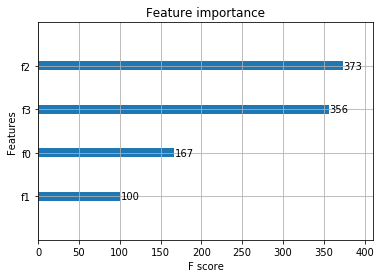

In [13]:
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot as plt

# 设置模型参数
params = {
    'booster': 'gbtree',
    'objective': 'multi:softmax',   
    'num_class': 3,     
    'gamma': 0.1,
    'max_depth': 2,
    'lambda': 2,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3,
    'eta': 0.001,
    'seed': 1000,
    'nthread': 4,
}


dtrain = xgb.DMatrix(X_train, y_train)
num_rounds = 200
model = xgb.train(params, dtrain, num_rounds)
# 对测试集进行预测
dtest = xgb.DMatrix(X_test)
y_pred = model.predict(dtest)

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print ("Accuracy:", accuracy)
# 绘制特征重要性
plot_importance(model)
plt.show();